### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')
plotsdir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/plots/" + x
GLORYS_dir = lambda x="": "/vortexfs1/home/anthony.meza/GLORYS_data" + x
GLORYS_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": "/vortexfs1/home/anthony.meza/scratch/ERA5_data/" + x

In [2]:
# from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
import matplotlib.pyplot as plt
import gsw
import gc
from multiprocessing import Pool
import os 
import multiprocessing
from os.path import exists
sns.set_context("notebook")
import dask_labextension
from pathlib import Path
import numpy as np
import dask
# dask.config.set({"array.slicing.split_large_chunks": False})

In [3]:
def remove_climatology(ds, climatology):
    ds = ds.convert_calendar('noleap') #remove leap years from operations
    anomalies = ds.groupby("time.dayofyear") - climatology
    anomalies["time"] = anomalies.indexes['time'].to_datetimeindex()
    anomalies["time"] = anomalies.indexes['time'].normalize()
    return anomalies

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='100GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=8)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=94G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.53:40242 --nthreads 36 --memory-limit 93.13GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.53:40242,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
%%time 
def _preprocess(ds):
    return ds[["thetao", "zos"]].sel(latitude = slice(-2, 60), longitude = slice(-150, -75), time = slice("1993", "2018"))

ds = xr.open_mfdataset(
        GLORYS_data_dir("GLORYS_NE_PAC.nc"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        preprocess=_preprocess,
        parallel=True,
        chunks={"time":320, "latitude":-1, "longitude":-1, "depth":1},
        engine="netcdf4")
ds_climatology = xr.open_dataset(GLORYS_data_dir("GLORYS_SFC_Climatology.nc"),
        chunks={"latitude":-1, "longitude":-1, "depth":1},
        engine="netcdf4")

glorys_anomalies = remove_climatology(ds, ds_climatology)
glorys_anomalies = glorys_anomalies["thetao"].isel(depth = 0)

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ... 

CPU times: user 1.16 s, sys: 129 ms, total: 1.29 s
Wall time: 34 s


/tmp/ipykernel_338482/1402945506.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  anomalies["time"] = anomalies.indexes['time'].to_datetimeindex()


In [7]:
def _preprocess_ERA5(ds):
    return ds.sel(latitude = slice(60, -2)).sel(longitude = slice(-150, -75)).sel(time = slice("1993", "2018"))

era5_ds = xr.open_mfdataset(GLORYS_data_dir("ERA5_NE_PAC_daily.nc"), 
        data_vars="minimal", coords="minimal",
        compat="override", preprocess=_preprocess_ERA5,
        parallel=True, chunks={"longitude": -1, "latitude":-1, "time":1000}, engine="netcdf4")
era5_climatology = xr.open_dataset(ERA5_data_dir("ERA5_Daily_Climatology.nc"),
                    chunks={"longitude": -1, "latitude":-1},
                    engine="netcdf4")
era5_anomalies = remove_climatology(era5_ds, era5_climatology)
# era5_anomalies = era5_anomalies.rolling(time=14, center=True).mean("time")

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tmp/ipykernel_338482/1402945506.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  anomalies["time"] = anomalies.indexes['time'].to_datetimeindex()


In [8]:
def _preprocess_ERA5(ds):
    return ds[["p71.162", "p72.162"]].sel(latitude = slice(60, -2)).sel(longitude = slice(-150, -75)).sel(time = slice("1993", "2018"))

era5_IVT_ds = xr.open_mfdataset(GLORYS_data_dir("ERA5_WaterVars_NE_PAC_daily.nc"), 
        data_vars="minimal", coords="minimal",
        compat="override", preprocess=_preprocess_ERA5,
        parallel=True, chunks={"longitude": -1, "latitude":-1, "time":320}, engine="netcdf4")
era5_IVT_climatology = xr.open_dataset(ERA5_data_dir("ERA5_WaterVars_Daily_Climatology.nc"),
                    chunks={"longitude": -1, "latitude":-1},
                    engine="netcdf4")
era5_IVT_anomalies = remove_climatology(era5_IVT_ds, era5_IVT_climatology)
# era5_IVT_anomalies = era5_IVT_anomalies.rename({"p71.162":"IVTE", "p72.162":"IVTN"})

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/tmp/ipykernel_338482/1402945506.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  anomalies["time"] = anomalies.indexes['time'].to_datetimeindex()


In [9]:
era5_IVT_anomalies.to_netcdf(GLORYS_data_dir("ERA5_WaterAnomaliesBandPass.nc"),
                             mode = "w", format = "NETCDF4", 
                             engine = "netcdf4", compute = True)

In [10]:
glorys_anomalies = glorys_anomalies.drop("depth")
glorys_anomalies.to_netcdf(GLORYS_data_dir("GLORYS_SST_AnomaliesBandPass.nc"),
             mode = "w", format = "NETCDF4", 
             engine = "netcdf4", compute = True)
era5_anomalies.to_netcdf(GLORYS_data_dir("ERA5_AnomaliesBandPass.nc"), 
                         mode = "w", format = "NETCDF4", 
                         engine = "netcdf4", compute = True)


In [17]:
era5_anomalies.isel(longitude = 1)

<xarray.Dataset>
Dimensions:    (latitude: 249, time: 9490)
Coordinates:
    longitude  float32 -149.8
  * latitude   (latitude) float32 60.0 59.75 59.5 59.25 ... -1.5 -1.75 -2.0
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2018-12-31
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Data variables:
    tcwv       (time, latitude) float32 dask.array<chunksize=(1000, 249), meta=np.ndarray>
    tp         (time, latitude) float32 dask.array<chunksize=(1000, 249), meta=np.ndarray>
    z          (time, latitude) float32 dask.array<chunksize=(1000, 249), meta=np.ndarray>

In [23]:
from scipy.signal import sosfiltfilt, butter, filtfilt
from copy import deepcopy
def filter_ds_fast(ds, axis = "time"):
    b, a = butter(2, [1/120, 1/20], btype='band', output='ba', fs = 1)
    nlon = len(ds.longitude)

    for key in ds.keys():
        print(key)
        for ilon in np.arange(0, nlon):
            axis_num = ds[key].isel(longitude = ilon).T.get_axis_num(axis)
            data = ds[key].isel(longitude = ilon).values.T
            wherenan = np.isnan(data)
            data[wherenan] = 0.0

            #apply filter to obtain a smooth daily climatology
            ysmooth = filtfilt(b, a, data, axis = axis_num, 
                                  padtype = None, padlen = 0)
            ysmooth[wherenan] = np.nan

            ds[key].values[..., ilon] = ysmooth.T

tcwv
tp
z


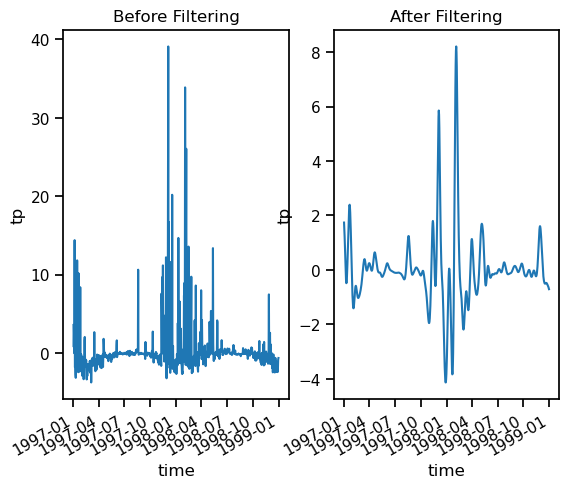

In [24]:
era5_anomalies =  xr.open_dataset(GLORYS_data_dir("ERA5_AnomaliesBandPass.nc")).compute()
fig, ax = plt.subplots(1, 2)
era5_anomalies.tp.isel(latitude = 100, longitude = 100).sel(time = slice("1997", "1998")).plot(ax = ax[0])
ax[0].set_title("Before Filtering")
filter_ds_fast(era5_anomalies)
era5_anomalies.tp.isel(latitude = 100, longitude = 100).sel(time = slice("1997", "1998")).plot(ax = ax[1])
ax[1].set_title("After Filtering")
era5_anomalies.to_netcdf(GLORYS_data_dir("ERA5_AnomaliesBandPass.nc"), compute = True)

tcwv
tp
z


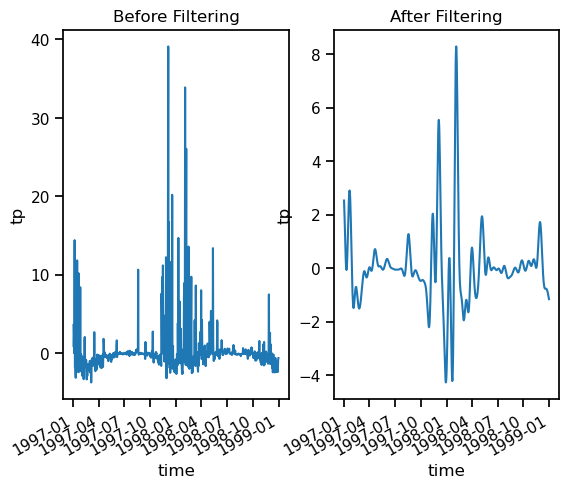

In [11]:
era5_anomalies =  xr.open_dataset(GLORYS_data_dir("ERA5_AnomaliesBandPass.nc")).compute()
fig, ax = plt.subplots(1, 2)
era5_anomalies.tp.isel(latitude = 100, longitude = 100).sel(time = slice("1997", "1998")).plot(ax = ax[0])
ax[0].set_title("Before Filtering")
filter_ds_fast(era5_anomalies)
era5_anomalies.tp.isel(latitude = 100, longitude = 100).sel(time = slice("1997", "1998")).plot(ax = ax[1])
ax[1].set_title("After Filtering")
era5_anomalies.to_netcdf(GLORYS_data_dir("ERA5_AnomaliesBandPass.nc"), compute = True)

p71.162
p72.162


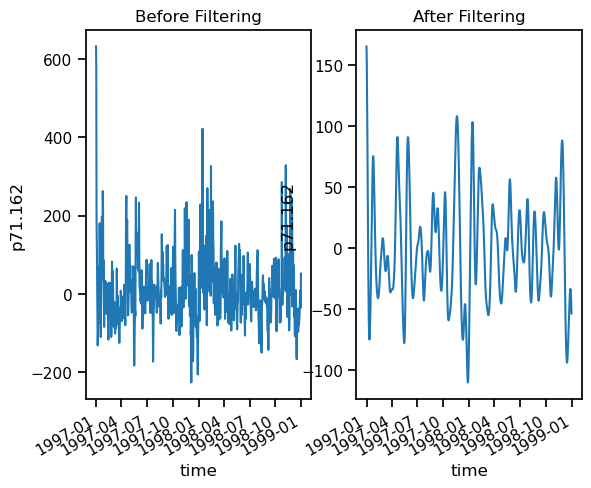

In [25]:
era5_IVT_anomalies =  xr.open_dataset(GLORYS_data_dir("ERA5_WaterAnomaliesBandPass.nc")).compute()
fig, ax = plt.subplots(1, 2)
era5_IVT_anomalies["p71.162"].isel(latitude = 100, longitude = 100).sel(time = slice("1997", "1998")).plot(ax = ax[0])
ax[0].set_title("Before Filtering")
filter_ds_fast(era5_IVT_anomalies)
era5_IVT_anomalies["p71.162"].isel(latitude = 100, longitude = 100).sel(time = slice("1997", "1998")).plot(ax = ax[1])
ax[1].set_title("After Filtering")
era5_IVT_anomalies.to_netcdf(GLORYS_data_dir("ERA5_WaterAnomaliesBandPass.nc"), compute = True)

thetao


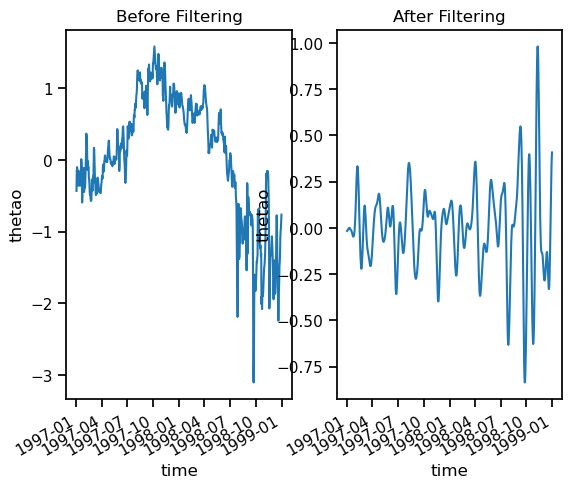

In [26]:
glorys_anomalies =  xr.open_dataset(GLORYS_data_dir("GLORYS_SST_AnomaliesBandPass.nc")).compute()
fig, ax = plt.subplots(1, 2)
glorys_anomalies["thetao"].isel(latitude = 100, longitude = 100).sel(time = slice("1997", "1998")).plot(ax = ax[0])
ax[0].set_title("Before Filtering")
filter_ds_fast(glorys_anomalies)
glorys_anomalies["thetao"].isel(latitude = 100, longitude = 100).sel(time = slice("1997", "1998")).plot(ax = ax[1])
ax[1].set_title("After Filtering")
glorys_anomalies.to_netcdf(GLORYS_data_dir("GLORYS_SST_AnomaliesBandPass.nc"), compute = True)

thetao


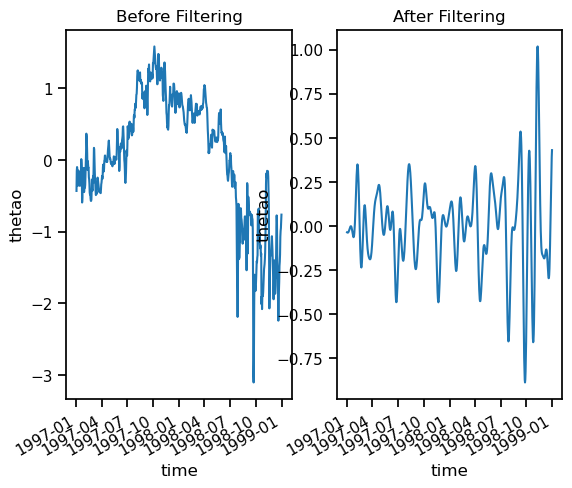

In [13]:
glorys_anomalies =  xr.open_dataset(GLORYS_data_dir("GLORYS_SST_AnomaliesBandPass.nc")).compute()
fig, ax = plt.subplots(1, 2)
glorys_anomalies["thetao"].isel(latitude = 100, longitude = 100).sel(time = slice("1997", "1998")).plot(ax = ax[0])
ax[0].set_title("Before Filtering")
filter_ds_fast(glorys_anomalies)
glorys_anomalies["thetao"].isel(latitude = 100, longitude = 100).sel(time = slice("1997", "1998")).plot(ax = ax[1])
ax[1].set_title("After Filtering")
glorys_anomalies.to_netcdf(GLORYS_data_dir("GLORYS_SST_AnomaliesBandPass.nc"), compute = True)